In [26]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [27]:
housing = pd.read_csv('../data/raw/NY-House-Dataset.csv')

display(housing.head())

print(f'\n----\nShape: {housing.shape}')

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856



----
Shape: (4801, 17)


In [28]:
print('Count of Unique Values in each Column:')

for col in housing.columns:
    print(f'{col} - {housing[col].dtype} - {len(housing[col].unique())}')

Count of Unique Values in each Column:
BROKERTITLE - object - 1036
TYPE - object - 13
PRICE - int64 - 1274
BEDS - int64 - 27
BATH - float64 - 22
PROPERTYSQFT - float64 - 1445
ADDRESS - object - 4582
STATE - object - 308
MAIN_ADDRESS - object - 4583
ADMINISTRATIVE_AREA_LEVEL_2 - object - 29
LOCALITY - object - 11
SUBLOCALITY - object - 21
STREET_NAME - object - 174
LONG_NAME - object - 2731
FORMATTED_ADDRESS - object - 4550
LATITUDE - float64 - 4196
LONGITUDE - float64 - 4118


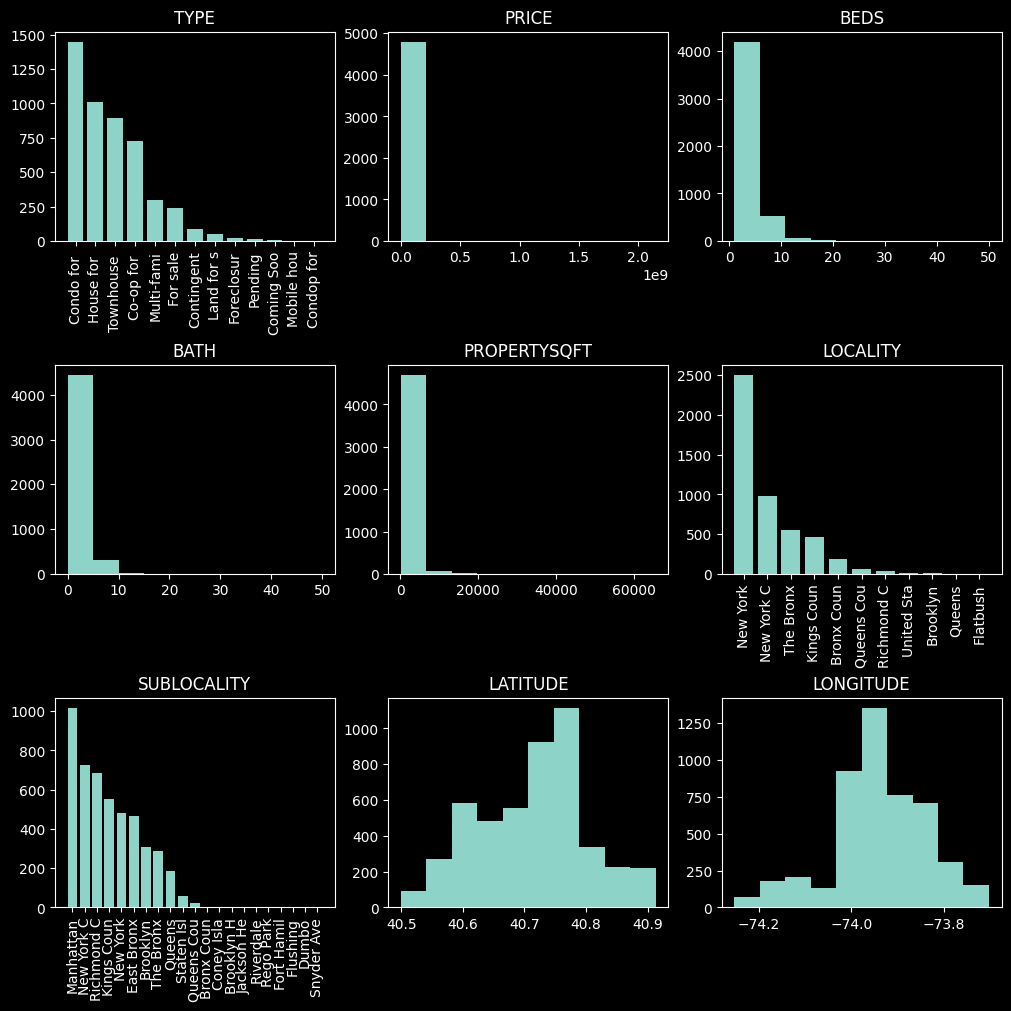

In [29]:
cols_for_hist = ['TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'LOCALITY', 'SUBLOCALITY', 'LATITUDE', 'LONGITUDE']

fig, axes = plt.subplots(3, 3, figsize=(10, 10), layout='constrained')

for col, ax in zip(cols_for_hist, axes.ravel()):
    if housing[col].dtype == 'object':
        ax.bar(housing[col].unique(), housing[col].value_counts())
        ax.set_xticks(range(len(housing[col].unique())))
        ax.set_xticklabels([s[:10] for s in housing[col].unique()], rotation=90)
    else:
        ax.hist(housing[col])
    ax.set_title(col)

In [30]:
print('Count of NAs in each Column:')

for col in housing.columns:
    print(f'{col} - {housing[col].dtype} - {len(housing.loc[housing[col].isna()])}')

Count of NAs in each Column:
BROKERTITLE - object - 0
TYPE - object - 0
PRICE - int64 - 0
BEDS - int64 - 0
BATH - float64 - 0
PROPERTYSQFT - float64 - 0
ADDRESS - object - 0
STATE - object - 0
MAIN_ADDRESS - object - 0
ADMINISTRATIVE_AREA_LEVEL_2 - object - 0
LOCALITY - object - 0
SUBLOCALITY - object - 0
STREET_NAME - object - 0
LONG_NAME - object - 0
FORMATTED_ADDRESS - object - 0
LATITUDE - float64 - 0
LONGITUDE - float64 - 0


## Preprocess

In [31]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from haversine import haversine

In [32]:
SCALE_TARGET = True
SCALE_FUNCTION = StandardScaler

In [33]:
empire_state = (40.748817, -73.985428)
housing['DISTANCE'] = housing.apply(lambda x: haversine(empire_state, (x.LATITUDE, x.LONGITUDE)), axis=1)

In [34]:
features_to_drop = ['BROKERTITLE', 'ADDRESS', 'FORMATTED_ADDRESS', 'MAIN_ADDRESS', 'LONG_NAME', 'LATITUDE', 'LONGITUDE']
features_to_onehot = ['TYPE', 'STATE', 'ADMINISTRATIVE_AREA_LEVEL_2', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME']
features_to_scale = [x for x in housing.columns if x not in features_to_drop and x not in features_to_onehot and x != 'PRICE']

In [35]:
scale_transfomer = Pipeline(steps=[
    ('scaler', SCALE_FUNCTION())
])

onehot_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('scale', scale_transfomer, features_to_scale),
    ('onehot', onehot_transformer, features_to_onehot)
])

In [36]:
X = housing.drop(features_to_drop + ['PRICE'], axis=1)
y = housing.PRICE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5)

print(
    f'--- Features ---\n'
    f'Train: {X_train.shape} - Valid: {X_valid.shape} - Test {X_test.shape}\n'
    f'--- Target ---\n'
    f'Train: {y_train.shape} - Valid: {y_valid.shape} - Test {y_test.shape}\n'
)

--- Features ---
Train: (2880, 10) - Valid: (960, 10) - Test (961, 10)
--- Target ---
Train: (2880,) - Valid: (960,) - Test (961,)



In [37]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test = preprocessor.transform(X_test)

if SCALE_TARGET:
    target_scaler = SCALE_FUNCTION()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_valid = target_scaler.transform(y_valid.values.reshape(-1, 1))
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1))

ValueError: A given column is not a column of the dataframe

In [ ]:
target_scaler.inverse_transform(y_train)

array([[ 850000.],
       [5995000.],
       [ 295000.],
       ...,
       [ 789000.],
       [2600000.],
       [1195000.]])